In [0]:
# /Volumes/workspace/sephora/product_info/product_info.csv
#!pip install missingno
#!pip install -U kaleido

In [0]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

In [0]:
sephora_products_df = pd.read_csv('/Volumes/workspace/sephora/product_info/product_info.csv')
sephora_products_df.head(2)

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,NaN,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0


In [0]:
sephora_products_df.describe(include='all')

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
count,8494,8494,8494.000000,8494,8.494000e+03,8216.000000,8216.000000,6863,7050,6896,1250,7549,8494.000000,451.000000,270.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,6287,8494,8486,7504,8494.000000,2754.000000,2754.000000
unique,8494,8415,NaN,304,NaN,NaN,NaN,2055,7,2729,935,6538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4417,9,41,118,NaN,NaN,NaN
top,P473671,Fragrance Discovery Set,NaN,SEPHORA COLLECTION,NaN,NaN,NaN,1.7 oz/ 50 mL,Size,1.7 oz/ 50 mL,black,"['Sugarcane Alcohol Denat., Fragrance/Parfum*,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['Layerable Scent', 'Floral Scent']",Skincare,Women,Perfume,NaN,NaN,NaN
freq,1,3,NaN,352,NaN,NaN,NaN,500,4043,374,46,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,2420,875,568,NaN,NaN,NaN
mean,NaN,NaN,5422.440546,NaN,2.917957e+04,4.194513,448.545521,NaN,NaN,NaN,NaN,NaN,51.655595,91.168537,20.207889,0.070285,0.071698,0.219096,0.073699,0.279374,NaN,NaN,NaN,NaN,1.631622,53.792023,39.665802
std,NaN,NaN,1709.595957,NaN,6.609212e+04,0.516694,1101.982529,NaN,NaN,NaN,NaN,NaN,53.669234,79.195631,24.327352,0.255642,0.258002,0.413658,0.261296,0.448718,NaN,NaN,NaN,NaN,5.379470,58.765894,38.685720
min,NaN,NaN,1063.000000,NaN,0.000000e+00,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,1.750000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,3.000000,3.000000
25%,NaN,NaN,5333.000000,NaN,3.758000e+03,3.981725,26.000000,NaN,NaN,NaN,NaN,NaN,25.000000,45.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,22.000000,19.000000
50%,NaN,NaN,6157.500000,NaN,9.880000e+03,4.289350,122.000000,NaN,NaN,NaN,NaN,NaN,35.000000,67.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,32.000000,28.000000
75%,NaN,NaN,6328.000000,NaN,2.684125e+04,4.530525,418.000000,NaN,NaN,NaN,NaN,NaN,58.000000,108.500000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,59.000000,42.000000


In [0]:
sephora_products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [0]:
sephora_products_df.isnull().sum()

product_id               0
product_name             0
brand_id                 0
brand_name               0
loves_count              0
rating                 278
reviews                278
size                  1631
variation_type        1444
variation_value       1598
variation_desc        7244
ingredients            945
price_usd                0
value_price_usd       8043
sale_price_usd        8224
limited_edition          0
new                      0
online_only              0
out_of_stock             0
sephora_exclusive        0
highlights            2207
primary_category         0
secondary_category       8
tertiary_category      990
child_count              0
child_max_price       5740
child_min_price       5740
dtype: int64

<Axes: >

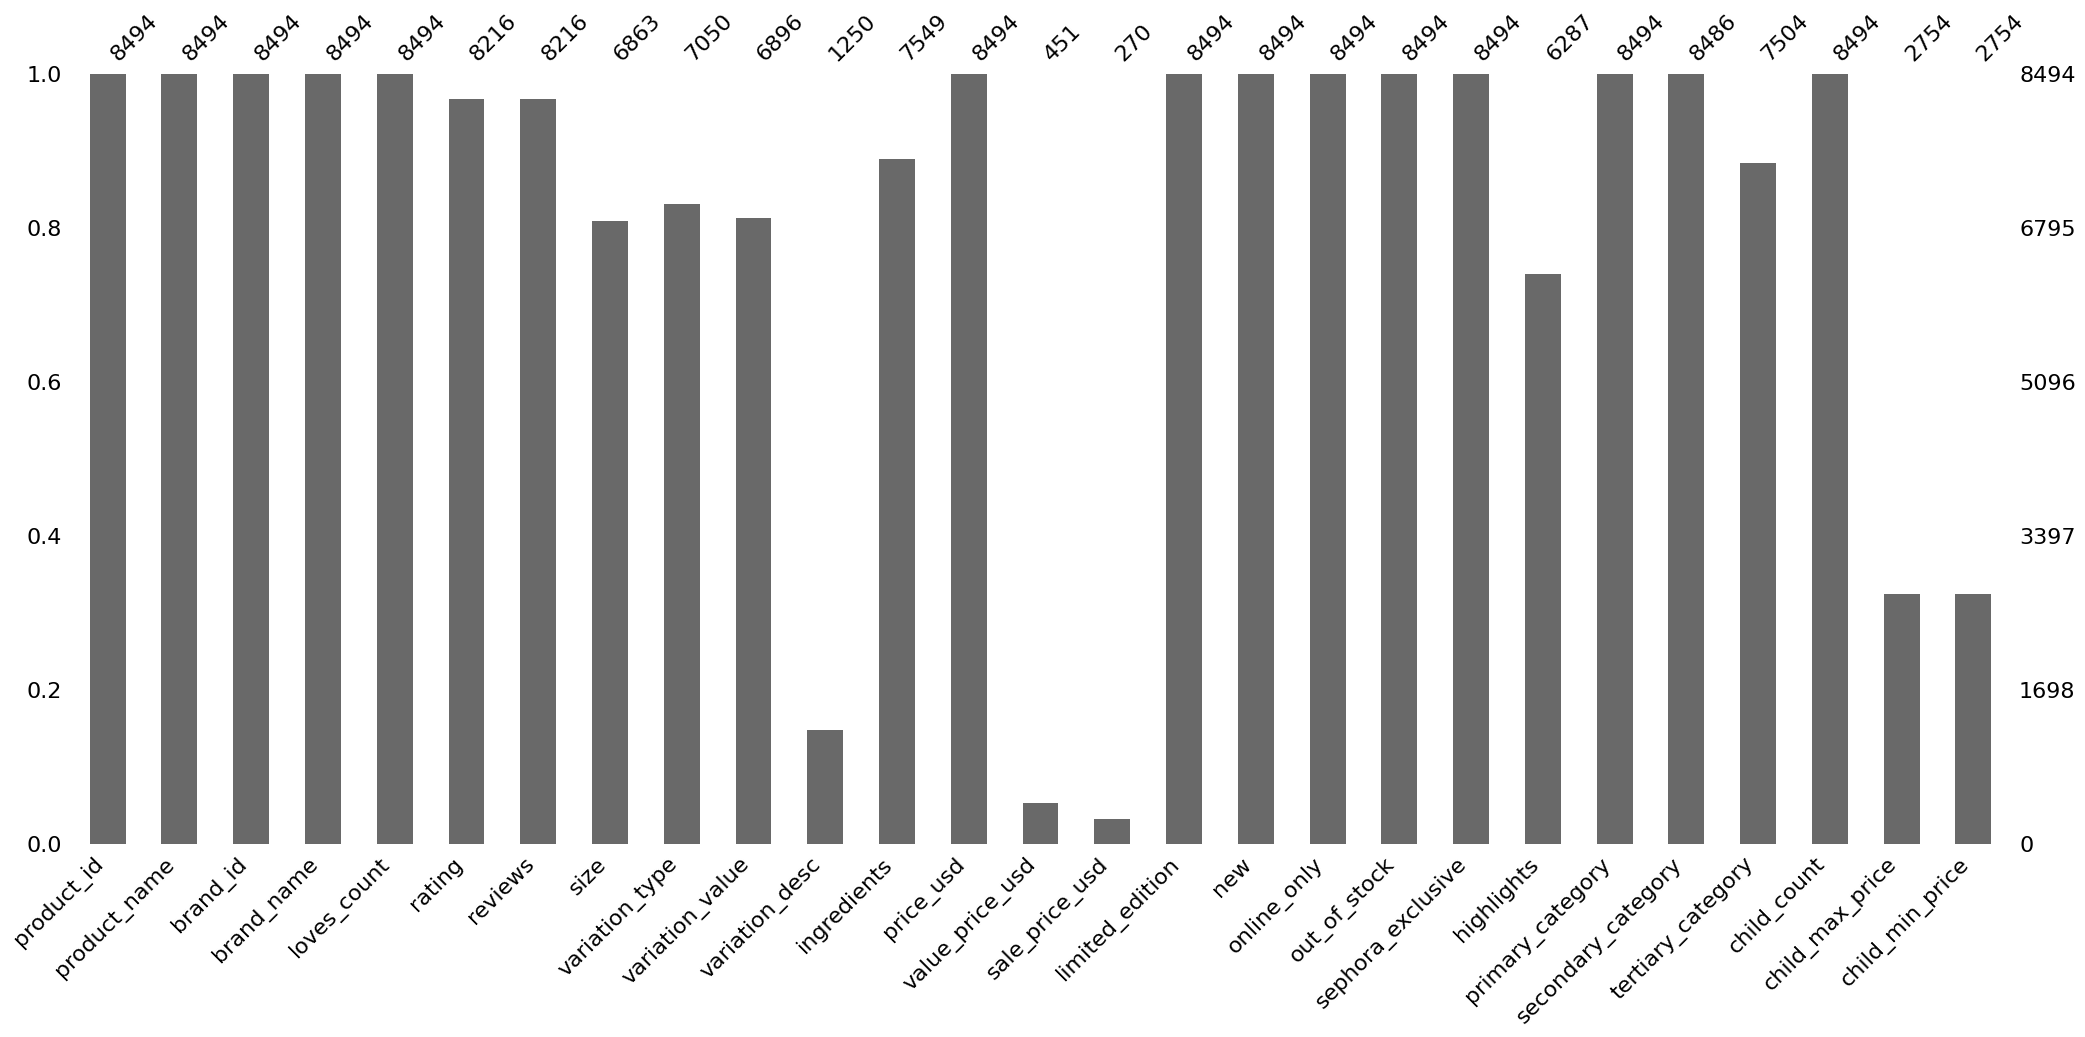

In [0]:
msno.bar(sephora_products_df)

In [0]:
sephora_products_df['product_name'] = sephora_products_df['product_name'].astype(str).str.strip()
sephora_products_df['brand_name'] = sephora_products_df['brand_name'].astype(str).str.strip()

sephora_products_df['rating'] = pd.to_numeric(sephora_products_df['rating'], errors='coerce').round(1)
sephora_products_df['reviews'] = pd.to_numeric(sephora_products_df['reviews'], errors='coerce')
sephora_products_df['price_usd'] = pd.to_numeric(sephora_products_df['price_usd'], errors='coerce')

sephora_products_df['sephora_exclusive'] = (sephora_products_df['sephora_exclusive']
                                            .astype(str)
                                            .str.strip()
                                            .str.lower()
                                            .map({'true':True, 'false': False })
                                            .astype(bool))

sephora_products_df['size'] = sephora_products_df['size'].fillna('None')
sephora_products_df['ingredients'] = sephora_products_df['ingredients'].fillna('None')

In size columns we have entiries like ml, oz, g also some rows has extra strings so lets normalize it

In [0]:
def convert_to_ml(size):
    if size == 'None':
        return None
    size = str(size).lower()
    matches = re.findall(r'(\d+(?:\.\d+)?)\s*(oz|ml|g)\b', size)
    if not matches:
        return None
    for value, unit in matches:
        value = float(value)
        if unit == 'ml':
            return round(value,2)
        elif unit == 'oz':
            return round(value * 29.5735, 2)
        elif unit == 'g':
            return round(value * 1, 2)
    return None
sephora_products_df['size_ml'] = sephora_products_df['size'].apply(convert_to_ml)

In [0]:
df = sephora_products_df[['product_name', 'brand_name', 'rating', 'reviews', 'size_ml', 'ingredients','price_usd','sephora_exclusive', 'primary_category','secondary_category','tertiary_category']]
df.head(2)

,product_name,brand_name,rating,reviews,size_ml,ingredients,price_usd,sephora_exclusive,primary_category,secondary_category,tertiary_category
0,Fragrance Discovery Set,19-69,3.6,11.0,NaN,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,True,Fragrance,Value & Gift Sets,Perfume Gift Sets
1,La Habana Eau de Parfum,19-69,4.2,13.0,100.55,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,True,Fragrance,Women,Perfume


In [0]:
df_size = df[df['ingredients'].isna()]
df_size

,product_name,brand_name,rating,reviews,size_ml,ingredients,price_usd,sephora_exclusive,primary_category,secondary_category,tertiary_category


In [0]:
df_category = (df.groupby(['primary_category','tertiary_category'], as_index=False)
               .agg({'product_name': 'count'})
               .rename(columns={'product_name': 'product_count'})
               .sort_values(['primary_category','product_count'], ascending=[True,False] ))

df_category = (df_category.groupby("primary_category")
               .head(3)
               .reset_index(drop=True))
df_category    

,primary_category,tertiary_category,product_count
0,Bath & Body,Body Lotions & Body Oils,197
1,Bath & Body,Body Wash & Shower Gel,51
2,Bath & Body,Intimate Care,28
3,Fragrance,Perfume,568
4,Fragrance,Rollerballs & Travel Size,287
5,Fragrance,Candles,193
6,Hair,Hair Styling Products,255
7,Hair,Shampoo,238
8,Hair,Conditioner,193
9,Makeup,Mascara,166


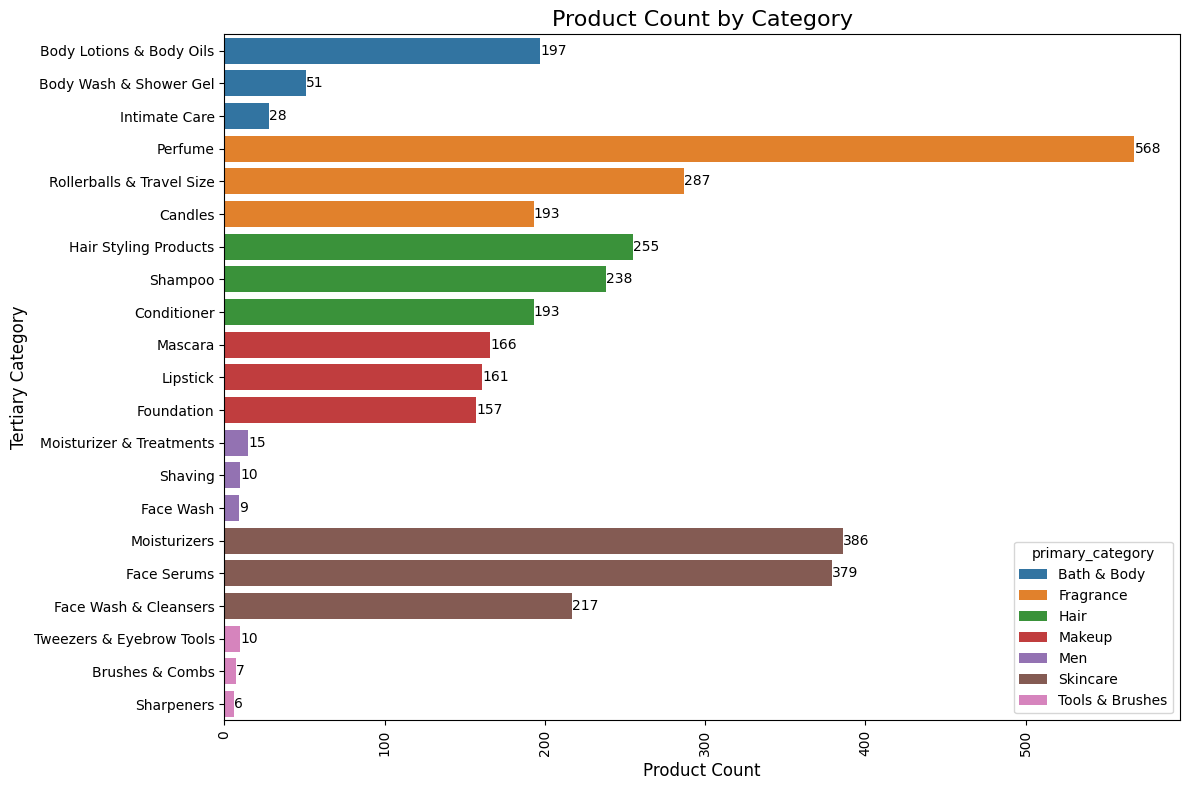

In [0]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=df_category, y='tertiary_category', x='product_count', hue='primary_category', dodge=False)

for container in ax.containers:
    ax.bar_label(container)

plt.title('Product Count by Category', fontsize=16)
plt.ylabel('Tertiary Category', fontsize=12)
plt.xlabel('Product Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [0]:
category_df = (df.groupby('primary_category', as_index=False)
               .agg({
                   'tertiary_category': lambda x: sorted(
                       set(v for v in x if pd.notna(v))
                       )}
               ))
category_df

,primary_category,tertiary_category
0,Bath & Body,"[Bath Soaks & Bubble Bath, Body Lotions & Body..."
1,Fragrance,"[Body Mist & Hair Mist, Candles, Cologne, Colo..."
2,Gifts,[]
3,Hair,"[Accessories, Brushes & Combs, Color Care, Con..."
4,Makeup,"[BB & CC Cream, Blotting Papers, Blush, Bronze..."
5,Men,"[Aftershave, Body Products, Eye Cream, Face Wa..."
6,Mini Size,[]
7,Skincare,"[Anti-Aging, BB & CC Creams, Beauty Supplement..."
8,Tools & Brushes,"[Accessories, Brush Sets, Brushes & Combs, Eye..."


In [0]:
category_df.loc[category_df['primary_category'] == 'Hair', 'tertiary_category'].iloc[0]

['Accessories',
 'Brushes & Combs',
 'Color Care',
 'Conditioner',
 'Curling Irons',
 'Damaged Hair',
 'Dry Shampoo',
 'Hair Dryers',
 'Hair Dye & Root Touch-Ups',
 'Hair Masks',
 'Hair Oil',
 'Hair Primers',
 'Hair Spray',
 'Hair Straighteners & Flat Irons',
 'Hair Styling Products',
 'Hair Supplements',
 'Hair Thinning & Hair Loss',
 'Leave-In Conditioner',
 'Scalp Treatments',
 'Shampoo']

In [0]:
df['brand_name'].value_counts()

brand_name
SEPHORA COLLECTION     352
CLINIQUE               179
Dior                   136
tarte                  131
NEST New York          115
                      ... 
Aquis                    1
Narciso Rodriguez        1
Jillian Dempsey          1
DOMINIQUE COSMETICS      1
iluminage                1
Name: count, Length: 304, dtype: int64

In [0]:
brand_df = (df.groupby('brand_name', as_index=False)
               .agg({
                   'primary_category': lambda x: sorted(set(v for v in x if pd.notna(v)))}))
brand_df

,brand_name,primary_category
0,19-69,[Fragrance]
1,54 Thrones,[Bath & Body]
2,ABBOTT,[Fragrance]
3,AERIN,"[Fragrance, Makeup, Mini Size]"
4,ALTERNA Haircare,[Hair]
...,...,...
299,philosophy,[Bath & Body]
300,rms beauty,[Makeup]
301,shu uemura,[Hair]
302,stila,"[Makeup, Mini Size]"


In [0]:
#brand_df.loc[brand_df['brand_name']=='shu uemura', 'tertiary_category'].iloc[0]

In [0]:
brand_review_df = (df.groupby(['brand_name','primary_category'], as_index=False)['reviews']
                   .sum()
                   .round(2)
                   .sort_values(['primary_category','reviews'], ascending=[True,False])
                   )
top3_brand_review_df = (brand_review_df.groupby('primary_category')
                         .head(3)
                         .reset_index(drop=True))
top3_brand_review_df                         

,brand_name,primary_category,reviews
0,Sol de Janeiro,Bath & Body,18275.0
1,L'Occitane,Bath & Body,6887.0
2,Moroccanoil,Bath & Body,5087.0
3,TOM FORD,Fragrance,34357.0
4,Yves Saint Laurent,Fragrance,27883.0
5,Dior,Fragrance,22509.0
6,SEPHORA COLLECTION,Gifts,68.0
7,Pureology,Hair,35177.0
8,Bumble and bumble,Hair,29866.0
9,Moroccanoil,Hair,28468.0


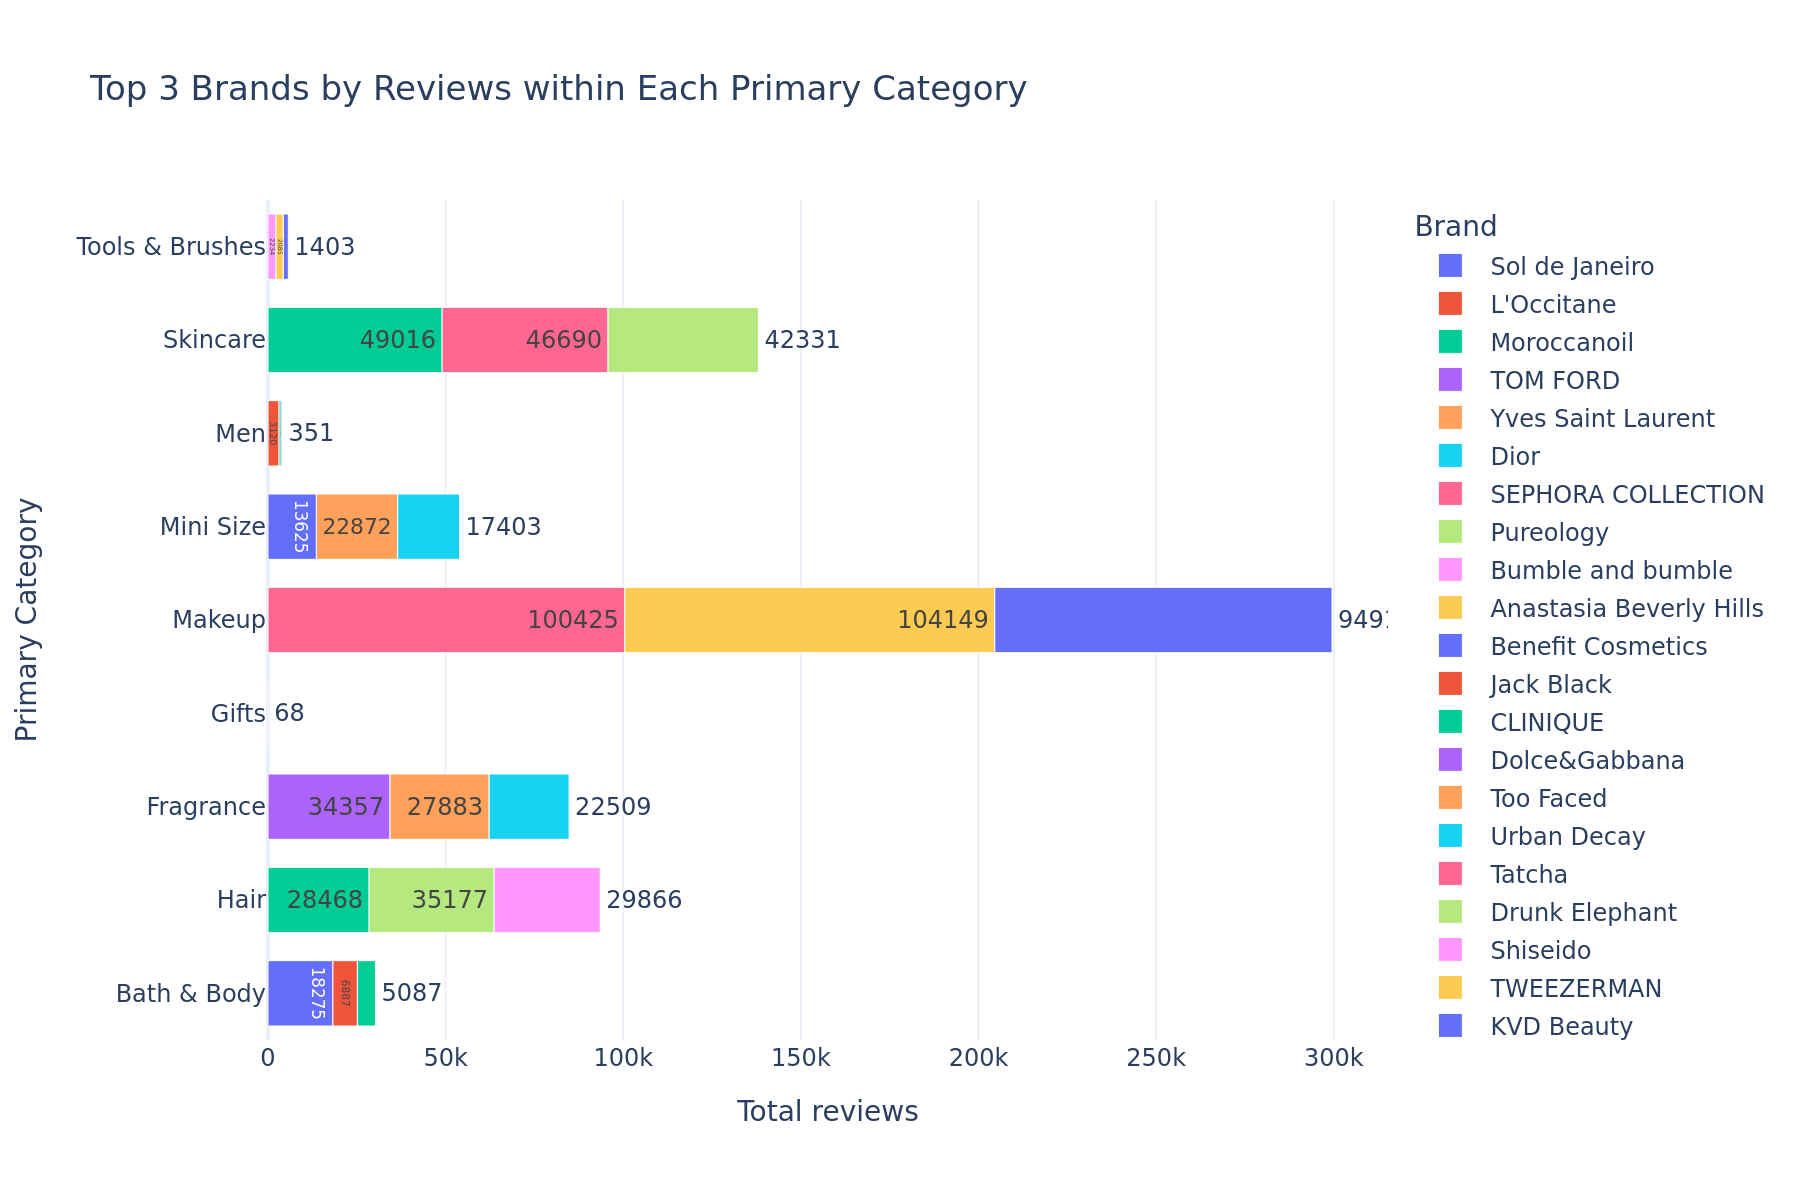

In [0]:
fig = px.bar(
    top3_brand_review_df,
    x='reviews',
    y='primary_category',
    color='brand_name',
    orientation='h',  # horizontal bars
    text='reviews',   # show numbers on bars
    hover_data=['brand_name', 'reviews', 'primary_category'],
    title='Top 3 Brands by Reviews within Each Primary Category'
)
fig.update_traces(marker_line_width=0.5, marker_line_color="white", textposition='outside')
fig.update_layout(
    xaxis_title='Total reviews',
    yaxis_title='Primary Category',
    legend_title='Brand',
    bargap=0.3,
    height=600,
    width=900,
    template='plotly_white'
)
#fig.show()
png_bytes = fig.to_image(format="png", scale=2)  # requires `pip install kaleido`
display(Image(png_bytes))

In [0]:
brand_rating_rev_df = (df.groupby(['brand_name','primary_category'], as_index=False)
                   .agg(
                        reviews_sum=('reviews', 'sum'),
                        avg_rating=('rating', 'mean'),
                        rating_count=('rating', 'count'))
                   .round(1)
                   .sort_values(['primary_category', 'reviews_sum', 'avg_rating','rating_count'], ascending=[True,False, False, False])
                   )
top3_brand_rating_rev_df = (brand_rating_rev_df.groupby('primary_category')
                         .head(3)
                         .reset_index(drop=True))
top3_brand_rating_rev_df 

,brand_name,primary_category,reviews_sum,avg_rating,rating_count
0,Sol de Janeiro,Bath & Body,18275.0,4.1,23
1,L'Occitane,Bath & Body,6887.0,4.5,15
2,Moroccanoil,Bath & Body,5087.0,4.3,13
3,TOM FORD,Fragrance,34357.0,4.2,66
4,Yves Saint Laurent,Fragrance,27883.0,4.6,34
5,Dior,Fragrance,22509.0,4.4,36
6,SEPHORA COLLECTION,Gifts,68.0,4.6,4
7,Pureology,Hair,35177.0,4.4,41
8,Bumble and bumble,Hair,29866.0,4.1,97
9,Moroccanoil,Hair,28468.0,4.1,60


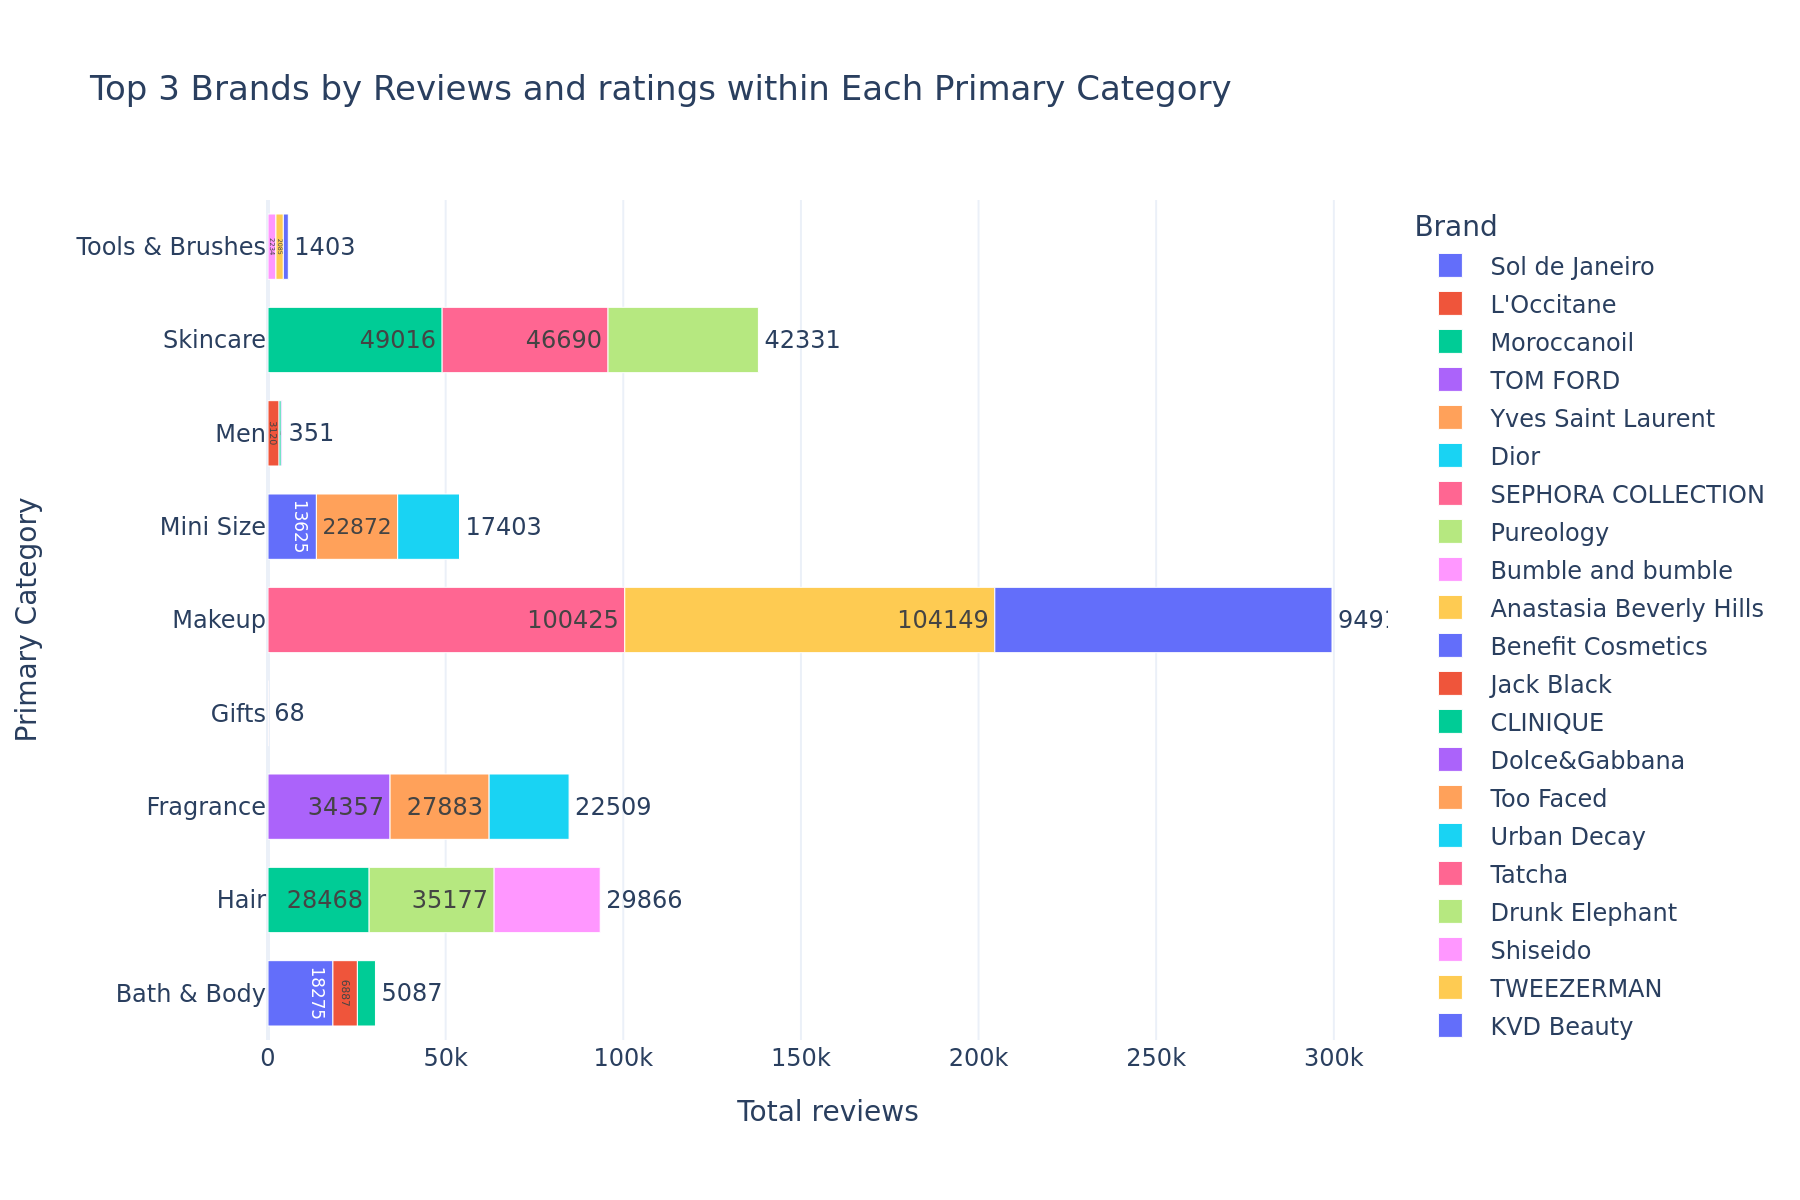

In [0]:
fig = px.bar(
    top3_brand_rating_rev_df,
    x='reviews_sum',
    y='primary_category',
    color='brand_name',
    orientation='h',  # horizontal bars
    text='reviews_sum',   # show numbers on bars
    hover_data=['brand_name', 'reviews_sum', 'avg_rating', 'rating_count'],
    title='Top 3 Brands by Reviews and ratings within Each Primary Category'
)
fig.update_traces(marker_line_width=0.5, marker_line_color="white", textposition='outside')
fig.update_layout(
    xaxis_title='Total reviews',
    yaxis_title='Primary Category',
    legend_title='Brand',
    bargap=0.3,
    height=600,
    width=900,
    template='plotly_white'
)
#fig.show()
png_bytes = fig.to_image(format="png", scale=2)  # requires `pip install kaleido`
display(Image(png_bytes))
